# Upper level tests
## Conjugate gradient

In [1]:
from algo.pdhg import pdhg

In [2]:
import numpy as np
from scipy.sparse.linalg import cg,LinearOperator
import scipy.optimize
import time

In [9]:
A = np.random.rand(512,512)
B = np.dot(A,A.transpose())
b = np.random.rand(512,)

t1=time.time()
x1,convergence = cg(B,b,tol=1e-10,
                    callback=lambda x:print(f"{np.linalg.norm(B.dot(x)-b)/np.linalg.norm(b)}"))
print(time.time()-t1)

0.5845646712297979
0.5208994593170698
0.5107321499225157
0.5014985726409519
0.48121346501612156
0.8135400386086715
0.565137457369808
0.4889531230679909
0.46923156100644503
0.5103362479285215
0.508012661373339
0.5476171499172658
1.4119219734054482
0.5333439882030807
0.5333434726818701
0.5371516445172685
0.5393798981688068
0.5621792867106107
1.4109960104226678
0.48915944360132063
0.5418312668901972
0.5826042379550943
0.5890973376103017
0.6529038427622172
1.4975377448240732
0.5696829788261064
0.5709185464267497
0.5788872148243095
0.5561919673983623
0.5595032135383465
2.144127793674238
0.5770126719985976
0.5699074348775987
0.5596246269058492
0.5756869575941395
0.9395979549096461
0.7509319573231604
0.61049290349256
0.6097056323188287
0.6383086479465686
0.6642655610883107
4.372751316546957
0.6147835000369517
0.5778727420501946
0.5654953524814056
0.5501192027806994
0.5614322835362594
1.6691838445497398
0.62681849353413
0.5979138591249962
0.5702311245418413
0.5744321301836944
0.582753653939354

7.261033040732436
1.1399154697092317
1.0872305627255092
0.9234182710707735
1.0164187431696599
18.85064491589302
0.752871541500383
0.8965736692610566
0.8162065084691779
0.8630327681967009
1.9007905282672357
0.8712879981681851
0.8480321308382421
1.0290640585441713
6.798385828431687
0.6656609852669755
0.702018806888602
0.6349785049382867
0.6675177876262857
8.685991131948228
0.767641789315578
0.5818285584221597
0.9012966659988534
1.5671598571158871
1.1944308940006305
0.8237471186877349
1.2806448642265034
1.0883580834001962
13.398561617512492
1.0484441168200238
1.2091503696631545
0.727210529046559
0.860103754215281
18.29041955091822
1.1171204371866117
0.9020261558243966
1.0534467016202058
1.0012690766934251
5.5595628642963995
0.9572221981553929
1.2206583605995442
1.0537927563036518
1.2835788010209623
2.04782869699224
1.3172390432400571
0.9774872150281436
1.3057194007774007
3.3325914910291363
1.1866889857490808
0.9677096203824576
1.1410146936754164
1.0876472783466433
4.96855143424935
0.83094

9.820463204928021e-09
6.4581550203070926e-09
1.0841882537352733e-08
8.922238250157508e-09
9.722003162192147e-09
9.14695164450534e-09
1.3507421173268661e-08
8.877722775105693e-09
9.32364471420051e-09
8.967405664685235e-09
2.8977839560622998e-08
8.837313123404111e-09
9.500747345175873e-09
9.604150559243648e-09
2.595866879482755e-08
9.292795538036332e-09
9.571488535372048e-09
9.359369493872167e-09
1.1232865746480388e-08
8.931913331407686e-09
9.852286095346478e-09
9.534372642475396e-09
1.0261166794312593e-08
4.289474594219138e-09
9.552477592431066e-09
9.916140236551086e-09
1.0024972464183318e-08
2.4507496037535046e-08
9.588490751916691e-09
9.841092749512686e-09
9.924183991081573e-09
4.599593006551016e-09
1.0079978696979115e-08
9.654583663963141e-09
9.571317589082919e-09
8.327471141011552e-09
9.867502394301772e-09
8.660071887812537e-09
8.678015518653259e-09
8.646351836393945e-09
1.473709022600122e-08
8.135605927771991e-09
7.196685271657268e-09
7.090230032472381e-09
4.3125055872354843e-08
8.

1.024506787101241e-08
1.0028056484160747e-08
1.0186908160003904e-08
1.0963620560317155e-08
1.2101658145732508e-08
1.4160805631707546e-08
1.4689550673220458e-08
1.709170142821758e-08
1.9616881581148522e-08
2.1473858058601526e-08
2.457787366674229e-08
2.7250001108768943e-08
3.184203134892871e-08
3.482524166672822e-08
3.6983860436368045e-08
3.841814979665938e-08
3.834526330425665e-08
3.6388096166140787e-08
3.357940937692691e-08
3.013750979915324e-08
2.603850213100101e-08
2.3454097055017583e-08
2.056874519682867e-08
1.8297090358277335e-08
1.7120654162550934e-08
1.5449616179728294e-08
1.4155205256524657e-08
1.307834278927504e-08
1.1982498345270373e-08
1.1334259979560557e-08
1.0250678320529655e-08
1.0860876991389276e-08
1.1437826942326788e-08
1.35138074025137e-08
1.691025092649999e-08
1.9215282775645438e-08
2.029903210827415e-08
2.015175425172895e-08
1.7789479903590232e-08
1.5688539033264153e-08
1.3357840146190338e-08
1.1498495170862515e-08
1.0592904535637242e-08
1.0701833877312546e-08
1.168

3.400508039780669e-08
3.423948619333025e-08
3.317100229057948e-08
3.0077790017411085e-08
2.672885467386585e-08
2.282963044292291e-08
1.9872860774126284e-08
1.6977484691663413e-08
1.5454690932565966e-08
1.3463922991327613e-08
1.2061141846861104e-08
1.100794869211877e-08
9.587268971925351e-09
9.46255025367173e-09
9.360492272505486e-09
9.898114466486488e-09
1.1318954657516557e-08
1.4027074532219424e-08
1.6891879683914344e-08
2.0548520342196308e-08
2.3211051466559086e-08
2.5510781215348928e-08
2.5924112371672886e-08
2.4390087938143884e-08
2.210894380971586e-08
1.8861548406849895e-08
1.548662649980798e-08
1.3470710139471615e-08
1.1969180919949873e-08
1.005133324073656e-08
9.488464285753228e-09
9.375024250524224e-09
9.784537421555883e-09
1.0551700791967346e-08
1.1511280223646112e-08
1.3466766874824678e-08
1.5236367618695413e-08
1.7364958570596542e-08
1.9839335217503477e-08
2.2564846271471427e-08
2.593037872790997e-08
2.8621889142854152e-08
3.174807649554098e-08
3.2716417913969664e-08
3.22164

1.510249344748383e-08
1.7030477944163927e-08
1.8769614090408073e-08
2.1090836018959768e-08
2.3112716072203843e-08
2.5115321093717876e-08
2.8131262903894017e-08
3.127353150629052e-08
3.5284661197909634e-08
3.9610786534552634e-08
4.4013802196284304e-08
4.866387962451311e-08
5.071855127619465e-08
5.1561086571353086e-08
4.963622202630651e-08
4.6722231300801375e-08
4.28346609681679e-08
3.8137801932528224e-08
3.376266373876509e-08
3.012508984231927e-08
2.7257939422520203e-08
2.5153972595168967e-08
2.3328503849197153e-08
2.136387732340163e-08
1.9223093218616652e-08
1.753120743684437e-08
1.5770734614554462e-08
1.3125091078254845e-08
1.1233725929169133e-08
1.0044280755770926e-08
1.0559181347416521e-08
1.2707944184272429e-08
1.5321388776419003e-08
1.7464249287891494e-08
1.8995923096272447e-08
1.7477598530167253e-08
1.611697602368467e-08
1.3800506516553744e-08
1.1212653541105235e-08
1.013401838944298e-08
1.0106002990976636e-08
1.1169618147517247e-08
1.2203416814671261e-08
1.382021416956226e-08
1.

In [10]:
#Using the LinearOperator of scipy.sparse.linalg
# ----------------------------------------------
#Function mv: returns a vector, result of the linear operator (equivalent to the product matrix-vector).
#This is useful since it's easier to compute express the linear operator than the matrix for Du2E
def mv(x):return np.dot(B,x)

#Defining the operator
B_linear = LinearOperator((512,512),matvec=mv)

#Solving
t1=time.time()
x2,convergence = cg(B_linear,b,tol=1e-10,
                    callback=lambda x:print(f"{np.linalg.norm(B.dot(x)-b)/np.linalg.norm(b)}"))
print(time.time()-t1)

0.5845646712297979
0.5208994593170698
0.5107321499225157
0.5014985726409519
0.48121346501612156
0.8135400386086715
0.565137457369808
0.4889531230679909
0.46923156100644503
0.5103362479285215
0.508012661373339
0.5476171499172658
1.4119219734054482
0.5333439882030807
0.5333434726818701
0.5371516445172685
0.5393798981688068
0.5621792867106107
1.4109960104226678
0.48915944360132063
0.5418312668901972
0.5826042379550943
0.5890973376103017
0.6529038427622172
1.4975377448240732
0.5696829788261064
0.5709185464267497
0.5788872148243095
0.5561919673983623
0.5595032135383465
2.144127793674238
0.5770126719985976
0.5699074348775987
0.5596246269058492
0.5756869575941395
0.9395979549096461
0.7509319573231604
0.61049290349256
0.6097056323188287
0.6383086479465686
0.6642655610883107
4.372751316546957
0.6147835000369517
0.5778727420501946
0.5654953524814056
0.5501192027806994
0.5614322835362594
1.6691838445497398
0.62681849353413
0.5979138591249962
0.5702311245418413
0.5744321301836944
0.582753653939354

1.0816711396477734
0.8672288687991191
1.0340091803880918
3.6968042837934263
1.2160520572128557
0.9094183634099083
1.119437470222123
0.9573177443466935
15.684289424295669
1.1856974775712765
1.2705684488049493
0.9538008048879334
1.1666797027404483
12.740686159490611
1.206284528216089
0.945111597748228
1.198868138686623
1.1947747303133307
1.7478046951432016
0.9740503478629058
0.9594397927974707
0.7847714114926392
7.261033040732436
1.1399154697092317
1.0872305627255092
0.9234182710707735
1.0164187431696599
18.85064491589302
0.752871541500383
0.8965736692610566
0.8162065084691779
0.8630327681967009
1.9007905282672357
0.8712879981681851
0.8480321308382421
1.0290640585441713
6.798385828431687
0.6656609852669755
0.702018806888602
0.6349785049382867
0.6675177876262857
8.685991131948228
0.767641789315578
0.5818285584221597
0.9012966659988534
1.5671598571158871
1.1944308940006305
0.8237471186877349
1.2806448642265034
1.0883580834001962
13.398561617512492
1.0484441168200238
1.2091503696631545
0.72

9.722003162192147e-09
9.14695164450534e-09
1.3507421173268661e-08
8.877722775105693e-09
9.32364471420051e-09
8.967405664685235e-09
2.8977839560622998e-08
8.837313123404111e-09
9.500747345175873e-09
9.604150559243648e-09
2.595866879482755e-08
9.292795538036332e-09
9.571488535372048e-09
9.359369493872167e-09
1.1232865746480388e-08
8.931913331407686e-09
9.852286095346478e-09
9.534372642475396e-09
1.0261166794312593e-08
4.289474594219138e-09
9.552477592431066e-09
9.916140236551086e-09
1.0024972464183318e-08
2.4507496037535046e-08
9.588490751916691e-09
9.841092749512686e-09
9.924183991081573e-09
4.599593006551016e-09
1.0079978696979115e-08
9.654583663963141e-09
9.571317589082919e-09
8.327471141011552e-09
9.867502394301772e-09
8.660071887812537e-09
8.678015518653259e-09
8.646351836393945e-09
1.473709022600122e-08
8.135605927771991e-09
7.196685271657268e-09
7.090230032472381e-09
4.3125055872354843e-08
8.086479726706204e-09
7.723800858054478e-09
8.1032222768133e-09
2.0225398148088496e-08
8.784

1.6406559571670438e-08
1.4740522636184686e-08
1.3275880869379386e-08
1.21204204677824e-08
1.0827073194785765e-08
1.0401514157634747e-08
1.0711346419997082e-08
1.267530201075665e-08
1.5970551024009278e-08
1.8353323941218894e-08
2.1116910652916598e-08
2.1864155935179166e-08
2.107204034488077e-08
1.8856924270557077e-08
1.5820299440797056e-08
1.3243199858252763e-08
1.1212123241702816e-08
1.0252767398605497e-08
1.052784575628593e-08
1.0573354911359354e-08
1.1728374282938316e-08
1.3118028269025914e-08
1.4750333210400137e-08
1.600098865238752e-08
1.8375993006604167e-08
2.0399918346515343e-08
2.308027641387664e-08
2.662960576074977e-08
2.995578529388262e-08
3.3408139712954784e-08
3.746330055490848e-08
3.99492904168263e-08
4.0260218521225563e-08
3.9441351894723945e-08
3.701242835780691e-08
3.3857583165841415e-08
3.081632972226091e-08
2.7311182124517593e-08
2.5047818657069773e-08
2.2049129728773055e-08
1.9500221130455164e-08
1.869208023905606e-08
1.714277782893008e-08
1.560889435133366e-08
1.367

1.2919488144698369e-08
1.1488864345958626e-08
1.0873117272355656e-08
1.037651951156495e-08
9.590867884444285e-09
9.560927342852034e-09
1.0366353655863527e-08
1.1868272425853457e-08
1.4234129725140421e-08
1.757506576170588e-08
2.13385841727499e-08
2.4602159242518634e-08
2.7328726041587675e-08
2.8497577793526983e-08
2.768228562313772e-08
2.551458281385145e-08
2.2729681814387368e-08
1.946749119745169e-08
1.727745259066059e-08
1.424561018115085e-08
1.2821082041708454e-08
1.1583909022900967e-08
1.0800080923052884e-08
1.0045439055589989e-08
9.323301139537984e-09
9.546895913418093e-09
1.0033430817322639e-08
1.0795829506077627e-08
1.2292904088811567e-08
1.439637939007469e-08
1.7600085715384747e-08
2.0019683634491888e-08
2.3322640738032186e-08
2.5840137940685e-08
2.7333752861967685e-08
2.7180208741658958e-08
2.5442886741802777e-08
2.2242902593111056e-08
1.9625341456241345e-08
1.598567842995947e-08
1.3733255365026352e-08
1.180620180172989e-08
1.0456332250999866e-08
9.814107644922302e-09
9.583137

1.4332179539340516e-08
1.6279737044779875e-08
1.7524686700417588e-08
2.0204318740316125e-08
2.241117804886537e-08
2.5024178317924404e-08
2.7134043347020323e-08
3.0016059922621186e-08
3.342058537684892e-08
3.666366267361578e-08
4.1549321796303565e-08
4.6162344402393626e-08
4.965569063414712e-08
5.082325187878118e-08
5.0806653801698716e-08
4.8745592028706033e-08
4.517825701339615e-08
4.0952813187769125e-08
3.550825351776308e-08
3.1988761217641896e-08
2.9029996107543655e-08
2.545623352033492e-08
2.268146528125969e-08
2.0986862100457837e-08
1.848114242999049e-08
1.6217298919520357e-08
1.4333725190146834e-08
1.2369730358211872e-08
1.1759092033694392e-08
1.0972192490008071e-08
1.2259220811276943e-08
1.4654171787743824e-08
1.8858478329318167e-08
2.152400717603334e-08
2.3596129292265932e-08
2.4023039209215972e-08
2.224834675683683e-08
2.0252454702901127e-08
1.6060077696735574e-08
1.3263266446399264e-08
1.2073406576374784e-08
1.1599006510375026e-08
1.2428783231435906e-08
1.418228177206623e-08
1

## LBFGS-B
First example: we find the subsampling operator $\mathcal{S}$ minimizing $||\mathcal{S}\mathcal{F}u_0-y||^2$ with y the full noised measurements, with and without regularisation.

In [6]:
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN
import pysap
from pysap.data import get_sample_data
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask
from modopt.math.metrics import ssim
import matplotlib.pyplot as plt

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [7]:
u0 = get_sample_data('2d-mri')
u0_mat = u0.data

n=512
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')

y = (1+0j)*fourier_op.op(np.real(u0.data))+1e-6*np.random.randn(2*n*n).view(np.complex128)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [8]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
p = np.zeros((n*n,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
p[n*ind1+ind2]=1

In [9]:
Fu = np.real(fourier_op.op(u0_mat))
y = np.real(y)

# -- Without regularisation
c1 = 1e7
f = lambda x:c1*np.linalg.norm(x*y-Fu)**2
grad_f = lambda x:2*c1*(x*y-Fu)*y

# -- With L2 regularisation
c2 = 1e7
k2 = 1e-5
f2 = lambda x:c2*np.linalg.norm(x*y-Fu)**2+k2*np.linalg.norm(x)**2
grad_f2 = lambda x:2*c2*(x*y-Fu)*y+2*k2*x

# -- With model
c3 = 1e7
k3 = 1e-5
f3 = lambda x:c3*np.linalg.norm(x*y-Fu)**2+k3*np.linalg.norm(x-p)**2
grad_f3 = lambda x:2*c3*(x*y-Fu)*y+2*k3*(x-p)

# -- With paper reg
c4 = 1e7
k4 = 1e-5
f4 = lambda x:c4*np.linalg.norm(x*y-Fu)**2+k4*np.sum(x*(1-x))
grad_f4 = lambda x:2*c4*(x*y-Fu)*y+k4*(1-2*x)

# -- Combination
c5 = 1e7
k4 = 2e-5
k5 = 1e-5
f5 = lambda x:c5*np.linalg.norm(x*y-Fu)**2+k5*np.linalg.norm(x-p)**2+k4*np.sum(x*(1-x))
grad_f5 = lambda x:2*c5*(x*y-Fu)*y+2*k5*(x-p)+k4*(1-2*x)


#Callback function
def pf(x):
    global l,f,npoints
    fx=f5(x)
    l.append(fx)
    npoints.append(sum(x))
    print(f"F(x)={fx}")

In [10]:
print(f(np.ones(512*512)),f2(np.ones(512*512)),f3(np.ones(512*512)),f4(0.8*np.ones(512*512)))

2.6249565736808114 5.246396573680812 4.948726573680812 3.9157763991585544


In [11]:
t1=time.time()
l,npoints=[],[]
res = scipy.optimize.minimize(f5,np.zeros(512*512),method='L-BFGS-B',jac=grad_f5,bounds=[(0,1)]*512*512,callback=pf,
                             options={'ftol':1e-6})
pf(res.x)
print(f"Time: {time.time()-t1}s")

F(x)=5.574808003757927
F(x)=5.300556985705894
F(x)=3.6890721380119427
F(x)=3.022597837475492
F(x)=2.60765884419492
F(x)=2.305079444694788
F(x)=2.2336456428802256
F(x)=2.027894344512133
F(x)=1.639969339875138
F(x)=1.5202922099517513
F(x)=1.4171431600564786
F(x)=1.3946359946419984
F(x)=1.382226907038943
F(x)=1.3021249595215283
F(x)=1.2470082593129128
F(x)=1.2323160705856755
F(x)=1.201631433962925
F(x)=1.1792296491811138
F(x)=1.1343211018483692
F(x)=1.0620387023718587
F(x)=1.0413600741014464
F(x)=1.0344843841905986
F(x)=1.0337093155258152
F(x)=1.0284576881583225
F(x)=0.9234799178327221
F(x)=0.9160129369595066
F(x)=0.8944212489597421
F(x)=0.8859375974255607
F(x)=0.8801600743483126
F(x)=0.873745754744236
F(x)=0.8517547252956578
F(x)=0.8451405906506546
F(x)=0.8424506733508311
F(x)=0.8234920595444863
F(x)=0.8226252101309505
F(x)=0.8161037429119776
F(x)=0.8139136745520958
F(x)=0.8135027695036239
F(x)=0.8073318289971712
F(x)=0.7872045487257495
F(x)=0.785058801755768
F(x)=0.7822456032864544
F(x)

F(x)=0.571007811525454
F(x)=0.5706342293616062
F(x)=0.570478950154561
F(x)=0.5701515934368567
F(x)=0.5699745085309222
F(x)=0.5697875154202031
F(x)=0.5696473253535161
F(x)=0.5695531769163524
F(x)=0.5694414526598848
F(x)=0.5691691989966697
F(x)=0.5690833932575914
F(x)=0.5690155114369564
F(x)=0.5688810366681593
F(x)=0.5688272097249407
F(x)=0.568720467119058
F(x)=0.568583118180056
F(x)=0.5681028370986426
F(x)=0.5679323085954231
F(x)=0.5678238105625542
F(x)=0.5677438837727524
F(x)=0.5676646520079872
F(x)=0.5674099013477496
F(x)=0.567001589759168
F(x)=0.5668952699613883
F(x)=0.5668551573326792
F(x)=0.566747749492118
F(x)=0.566672082273721
F(x)=0.5665978997972275
F(x)=0.5663787088803873
F(x)=0.5662814753493554
F(x)=0.5660284562835463
F(x)=0.5655350685296052
F(x)=0.565203090424882
F(x)=0.565064758728341
F(x)=0.5647745014585746
F(x)=0.564592147721676
F(x)=0.5642271044903361
F(x)=0.564169027118146
F(x)=0.564136709920519
F(x)=0.5641035821019097
F(x)=0.5640761378691426
F(x)=0.5639946864286662
F(x)

F(x)=0.5251005609803212
F(x)=0.5250743873209052
F(x)=0.5250314148163832
F(x)=0.5250006749505297
F(x)=0.5249712109376652
F(x)=0.5246886733287451
F(x)=0.5246337869002462
F(x)=0.524581809539396
F(x)=0.52443453674101
F(x)=0.5243585953826537
F(x)=0.5242116063055353
F(x)=0.524178529521882
F(x)=0.5241555912494444
F(x)=0.524134556327025
F(x)=0.5240883503330591
F(x)=0.5240297039613075
F(x)=0.5239523872894983
F(x)=0.5239106267432563
F(x)=0.5238644300483317
F(x)=0.5238403490786392
F(x)=0.5237781601049877
F(x)=0.5236054426010472
F(x)=0.5234667070931205
F(x)=0.5234254666464295
F(x)=0.5233471645981316
F(x)=0.5233124618517964
F(x)=0.5231547000944937
F(x)=0.5231208583174978
F(x)=0.5230982147480444
F(x)=0.5230348792455148
F(x)=0.5229950019112609
F(x)=0.5229242561671249
F(x)=0.5228556416845405
F(x)=0.5227397726923473
F(x)=0.5225771912563651
F(x)=0.5225330113094656
F(x)=0.5225016383184913
F(x)=0.5223808103113831
F(x)=0.5223238605280287
F(x)=0.5222824972644454
F(x)=0.5222441094247225
F(x)=0.52223450234085

F(x)=0.5066612903725077
F(x)=0.5066355501664189
F(x)=0.506600120878823
F(x)=0.5065769489745928
F(x)=0.5065564815437965
F(x)=0.5065395557541595
F(x)=0.5064989573214578
F(x)=0.5064603839546863
F(x)=0.5064157372704947
F(x)=0.5063802760276327
F(x)=0.506351033241937
F(x)=0.5063362443381239
F(x)=0.5063237665436527
F(x)=0.5063172990669504
F(x)=0.5062956754226169
F(x)=0.5062686723125331
F(x)=0.50623377928275
F(x)=0.5062183350907674
F(x)=0.506130245396473
F(x)=0.5061120935548726
F(x)=0.506086231334553
F(x)=0.5060769191042683
F(x)=0.5060599496889573
F(x)=0.5059573243278137
F(x)=0.505942677171248
F(x)=0.5059320965050688
F(x)=0.505913125817161
F(x)=0.5058941835046202
F(x)=0.5058750973212424
F(x)=0.5058609823145851
F(x)=0.505824449973085
F(x)=0.505815957740074
F(x)=0.5058007308908983
F(x)=0.505794393636026
F(x)=0.5057837422429003
F(x)=0.5057704359250227
F(x)=0.5057519984685355
F(x)=0.5057026647132986
F(x)=0.5056957787134936
F(x)=0.505683852558886
F(x)=0.5056803727014194
F(x)=0.5056706540940175
F(x)

F(x)=0.5003976468709679
F(x)=0.5003927979232328
F(x)=0.5003873012307974
F(x)=0.5003836189200548
F(x)=0.5003703389542098
F(x)=0.5003656149054296
F(x)=0.500346412253001
F(x)=0.5003350959517939
F(x)=0.5003281302968076
F(x)=0.5003218802608861
F(x)=0.5003174675778724
F(x)=0.5003099038142466
F(x)=0.5003073732005634
F(x)=0.5003025388539719
F(x)=0.5002952876827198
F(x)=0.5002855287352596
F(x)=0.5002780119036718
F(x)=0.500265894558709
F(x)=0.5002592855651083
F(x)=0.5002379870835238
F(x)=0.5002281152858342
F(x)=0.500223958825474
F(x)=0.5002219516751785
F(x)=0.5002191174401102
F(x)=0.5002152232438656
F(x)=0.5002079426433174
F(x)=0.5001946483865616
F(x)=0.5001780266943768
F(x)=0.5001570057879196
F(x)=0.5001506623285
F(x)=0.5001443045689741
F(x)=0.5001098301124103
F(x)=0.5000944479445715
F(x)=0.5000824380909528
F(x)=0.500069699076574
F(x)=0.500064840895061
F(x)=0.5000602869958579
F(x)=0.5000577827515499
F(x)=0.500050864132757
F(x)=0.5000434126234004
F(x)=0.5000272221560663
F(x)=0.5000050001467383
F

In [12]:
print(f(res.x),f2(res.x),f3(res.x),f4(res.x),f5(res.x))

0.2805417736025722 0.4795860074080467 0.4470419070322039 0.3320847898099936 0.49858492323962533


In [13]:
#Number of points close to 0 or 1
sum(np.where(res.x<0.1,1,0))+sum(np.where(res.x>0.9,1,0))

249764

Without regularisation (function f), ~162000/262144 points are <0.1 or >0.9. With paper regularisation (function f4), more than 245000 are (with k4=1e-5).

1606


Text(0.5, 1.0, 'Evolution of cost function')

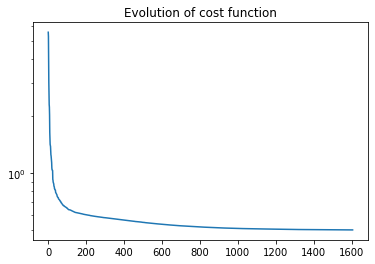

In [14]:
print(len(l))
plt.plot(l)
plt.yscale("log")
plt.title("Evolution of cost function")

Text(0.5, 1.0, 'Evolution of number of points in mask')

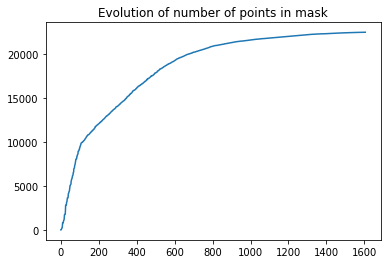

In [15]:
plt.plot(npoints)
plt.title("Evolution of number of points in mask")
#plt.savefig("Upper_level_tests_results/full_pen.png")

In [18]:
pysap.Image(data=np.reshape(res.x,u0.shape)).show()

### Multiple images

In [1]:
import nibabel as nib
import h5py

In [2]:
images = nib.load("oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii")
images = images.get_fdata()
u0 = images[ :, :, 124 ]
u0_mat = u0.data

In [121]:
pysap.Image(data=images[:,:,20]).show()

In [68]:
image_set = images[:,:,120:130]

In [69]:
n=512
x = np.linspace(0,n,n,endpoint=False)/n-0.5
y = np.linspace(0,n,n,endpoint=False)/n-0.5
X,Y = np.meshgrid(x,y)
kspace_loc = np.stack([X.flatten('F'),Y.flatten('F')],axis=1)

m = convert_locations_to_mask(kspace_loc,u0.shape)
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')

y = (1+0j)*fourier_op.op(np.real(u0.data))+20*np.random.randn(2*n*n).view(np.complex128)
measures_set = [(1+0j)*fourier_op.op(np.real(image_set[:,:,i]))+15*np.random.randn(2*n*n).view(np.complex128)
                for i in range(10)]

In [70]:
print(ssim(u0_mat,fourier_op.adj_op(y)))
pysap.Image(data = fourier_op.adj_op(measures_set[0])).show()

0.7015147183463798


In [71]:
#Subsampling: From pysap radial mask 
radial_mask = get_sample_data("mri-radial-samples")
radial_kspace_loc = radial_mask.data
p = np.zeros((n*n,))

ind1 = ((n-1)*(radial_kspace_loc[:,0]+0.5)).astype(int)
ind2 = ((n-1)*(radial_kspace_loc[:,1]+0.5)).astype(int)
p[n*ind1+ind2]=1

In [110]:
# -- Without regularisation
c1 = 1e-9
f = lambda x:c1*sum([np.linalg.norm(np.real(x*measures_set[i]-fourier_op.op(image_set[:,:,i]))) 
                                            for i in range(4)])**2
def grad_f(x):
    s=np.zeros(x.shape)
    for i in range(5):
        y=np.real(measures_set[i])
        Fu=np.real(fourier_op.op(image_set[:,:,i]))
        s += 2*c1*(x*y-Fu)*y
    return s

# -- With model
c3 = 1e-9
k3 = 1e-6
f3 = lambda x:c3*sum([np.linalg.norm(np.real(x*measures_set[i]-fourier_op.op(image_set[:,:,i]))) 
                                            for i in range(4)])**2 + k3*np.linalg.norm(x-p)**2
def grad_f3(x):
    s=2*k3*(x-p)
    for i in range(5):
        y=np.real(measures_set[i])
        Fu=np.real(fourier_op.op(image_set[:,:,i]))
        s += 2*c3*(x*y-Fu)*y
    return s


#Callback function
def pf(x):
    global l,f,npoints
    fx=f(x)
    l.append(fx)
    npoints.append(sum(x))
    print(f"F(x)={fx}")

In [111]:
print(f(np.zeros(512*512)),f3(np.zeros((512*512))))

13.283377368618082 13.313144368618081


In [112]:
t1=time.time()
l,npoints=[],[]
res = scipy.optimize.minimize(f3,np.zeros((512,512)),method='L-BFGS-B',jac=grad_f3,bounds=[(0,1)]*512*512,callback=pf,
                             options={'ftol':1e-4})
pf(res.x)
print(f"Time: {time.time()-t1}s")

F(x)=6.607241749013923
F(x)=2.958742192899861
F(x)=2.3389044286962224
F(x)=1.9300913010488745
F(x)=1.7557824253488972
F(x)=1.6204653898583952
F(x)=1.3528309129023677
F(x)=1.2507419098679196
F(x)=1.1512324993298257
F(x)=1.0865129581760449
F(x)=1.0485830974379837
F(x)=1.038636990218297
F(x)=0.8466924803541995
F(x)=0.8128229697484877
F(x)=0.8009452438740213
F(x)=0.7358141275638699
F(x)=0.6923549966135814
F(x)=0.684657759988975
F(x)=0.677101602700103
F(x)=0.6668660270650627
F(x)=0.5287310431196657
F(x)=0.49225137890087006
F(x)=0.48366832241143887
F(x)=0.4504921545090004
F(x)=0.4136399366050052
F(x)=0.41063304899509473
F(x)=0.4099112574832527
F(x)=0.40704469161091367
F(x)=0.3838755091902873
F(x)=0.3785940644354516
F(x)=0.3779089868002789
F(x)=0.375006360670685
F(x)=0.3618611278078712
F(x)=0.359615999688863
F(x)=0.34383986298877595
F(x)=0.31927500145086624
F(x)=0.3117020155538305
F(x)=0.3090243296324899
F(x)=0.3085380123084703
F(x)=0.30590114450656
F(x)=0.29648593721668925
F(x)=0.29154257977

120


Text(0.5, 1.0, 'Evolution of cost function')

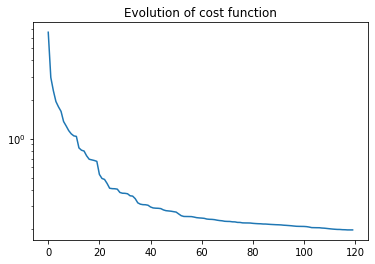

In [113]:
print(len(l))
plt.plot(l)
plt.yscale("log")
plt.title("Evolution of cost function")

Text(0.5, 1.0, 'Evolution of number of points in mask')

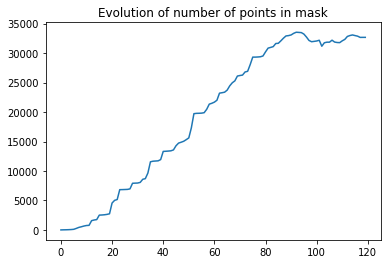

In [114]:
plt.plot(npoints)
plt.title("Evolution of number of points in mask")
#plt.savefig("Upper_level_tests_results/full_pen.png")

In [116]:
pysap.Image(data=np.reshape(res.x,(512,512))).show()

In [108]:
print(f(res.x),f3(res.x))

0.31376571007956733 0.3637225479699645
